# Battle at the Berrics Analysis

In this project, I will analyze various aspects of the annual Battle at the Berrics competition, hosted by Berrics. The competition is tournament style, where each match is a game of S.K.A.T.E. Similar to the basketball game H.O.R.S.E., “Roshambo” (rock, paper, scissors) is played to see who sets first (who is on offense). The setter does a trick, and then the defender must repeat the trick. If the defender misses, they get a letter. If the setter misses, it is the other player’s turn to set. The first person to get five letters loses the game.  

First, we will import the neccesary libraries.

In [1]:
import warnings
import json
import numpy as np
import statistics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_decision_regions
from scipy import stats
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

Next we will suppress warnings.

In [2]:
warnings.filterwarnings("ignore")

We will read the JSON file into a dictionary using the json module. Then we will save the dictionary under the SKATE_DATA global variable.

In [3]:
def read_json(filename):
    '''
    This function reads a json file to a dictionary

    Parameters
    ----------
    filename : TYPE: string
        DESCRIPTION: name of the file

    Returns
    -------
    skate_data : Dictionary
        A dictionary containing data from the json file.

    '''
    with open(filename) as infile:
        skate_data = json.loads(infile.read())
    return skate_data
# create global varibale: SKATE_DATA
SKATE_DATA = read_json("batb_data.json")

## Trick Consistency

The first topic we will investigate is trick consistency, in other words, how often each trick is performed and landed successfully. The hypothesis is that relatively basic tricks such as the kickflip, heelflip, 360 flip, and their variations will have high make rates, while harder and more unorthodox tricks will have lower make rates. I will investigate by making three bar graphs. 
First, a bar graph selecting the 15 most popular tricks and their make rates. Second, 15 tricks I find interesting or personally like. And third, a histogram with all of the tricks. I will also calculate the overall and median trick consistencies, and the trick associated with the median. 

First, we will create a pandas DataFrame containing information on each of the tricks performed. We will add columns for make and miss counts, total attempt count, and make rate.

In [4]:
def tricks_info():
    '''
    This function creates a dataframe containing trick information for each 
    trick. 

    Returns
    -------
    tricks_df : DataFrame
        A DataFrame containing information on each trick such as land rate and 
        variation.

    '''
    # create the data frame
    tricks_dict = SKATE_DATA['data']['tricks'] 
    tricks_df = pd.DataFrame(tricks_dict)
    
    # sort the tricks by trick id
    tricks_df = tricks_df.sort_values('id',ascending=True)
    
    # replace null variation values with 'regular'
    tricks_df.fillna({'variation': 'regular'}, inplace=True)
    # iterate through the data frame and extract make and miss counts for each trick
    # do this using an array
    success_array  = []
    for trick in tricks_df['attempts']:
        make_count = 0
        miss_count = 0
        for attempt in trick:
            if attempt['successful'] ==  True:
                make_count += 1
            else:
                miss_count += 1
        success_array.append([make_count,miss_count])
    success_array = np.array(success_array)
    
    # add make and miss count columns with data
    tricks_df = tricks_df.assign(make_count=success_array[:,0],miss_count=success_array[:,1])
    
    # drop the attempts column (the dictionary)
    tricks_df = tricks_df.drop(columns='attempts')
    
    # create columns for total attempts and make rate
    tricks_df['attempt_count'] = tricks_df['make_count'] + tricks_df['miss_count']
    tricks_df['make_rate'] = tricks_df['make_count'] / tricks_df['attempt_count']
    
    
    # return the data frame
    return tricks_df
# create a global variable
tricks = tricks_info()
tricks

,id,name,variation,make_count,miss_count,attempt_count,make_rate
173,1,Kickflip,regular,548,21,569,0.963093
92,100,Fakie Inward Heelflip,fakie,67,36,103,0.650485
151,101,Halfcab Inward Heelflip,fakie,11,15,26,0.423077
298,102,Switch Frontside Bigspin Heelflip,switch,1,1,2,0.500000
177,103,Late Frontside Shuv-it,regular,0,0,0,NaN
...,...,...,...,...,...,...,...
102,95,Fakie Varial Heelflip,fakie,45,26,71,0.633803
124,96,Frontside Bigspin Heelflip,regular,0,0,0,NaN
38,97,Backside Bigspin Kickflip,regular,7,1,8,0.875000
103,98,Fakie Varial Kickflip,fakie,40,14,54,0.740741


#### Graph 1: Most Popular Tricks and Their Make Rates

Next, we will make the first bar graph, selecting the 15 most popular tricks (tricks done the most often).

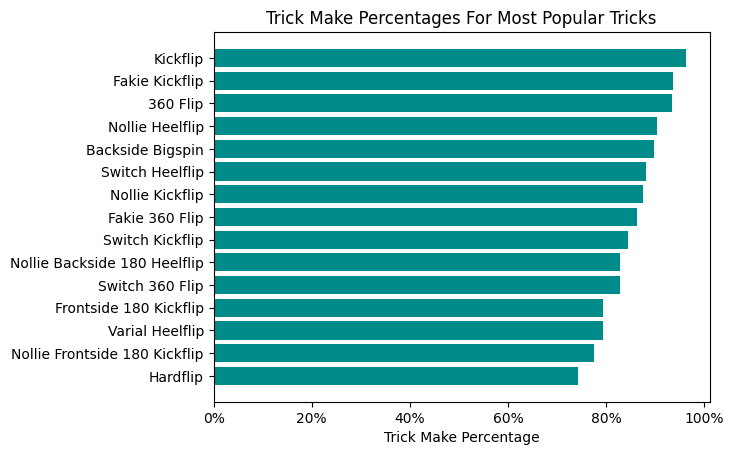

In [5]:
def plot_trick_makes_bar_popular():
    '''
    This function creates a bar graph of the top 15 most popular tricks and their make rates.

    Returns
    -------
    None.

    '''
    tricks_df = tricks.copy()
    
    # sort by attempt count to get most popular tricks, then sort by make rate
    tricks_df = tricks_df.sort_values('attempt_count',ascending=False)
    tricks_df = tricks_df.iloc[:15]
    tricks_df = tricks_df.sort_values('make_rate',ascending=True)
    
    # create the bar graph
    plt.barh(tricks_df['name'],tricks_df['make_rate'],color='darkcyan')
    
    # change decimal rates to percentages
    plt.xticks([0,0.2,0.4,0.6,0.8,1.0],['0%','20%','40%','60%','80%','100%'])
    
    # label the axis and title, save figure
    plt.xlabel('Trick Make Percentage')
    plt.title('Trick Make Percentages For Most Popular Tricks')
    plt.grid(False)
    plt.savefig('trick_bar_graph1',dpi=300,bbox_inches='tight')

    # show
    plt.show()

# call the function
plot_trick_makes_bar_popular()

As we can see, the 15 most commonly done tricks have very high make rates, with kickflips having the highest make rate out of these, at 96.31%.

#### Graph 2: Hand-Selected Tricks and Their Make Rates

Next, we will make similar bar graph, but instead hand selecting tricks that I like or find interesting.

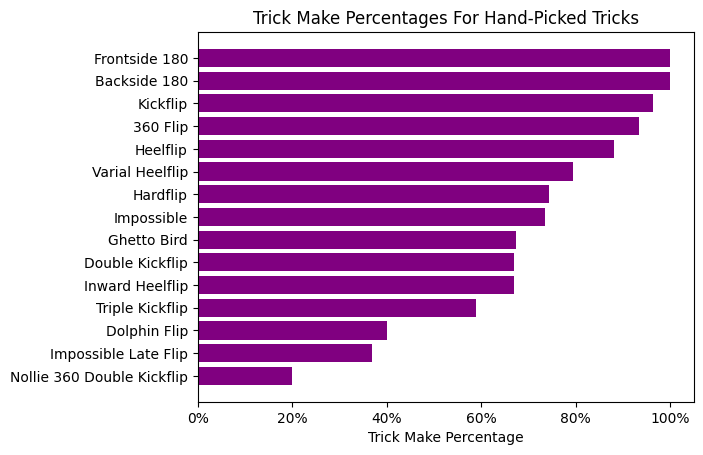

In [6]:
def plot_trick_makes_bar_hand_picked():
    '''
    This function creates a bar graph of hand picked tricks and their make rates.

    Returns
    -------
    None.

    '''
    # create a list of tricks we would lik to display
    trick_lst  = ['Kickflip',
                  'Heelflip',
                  '360 Flip', 
                  'Impossible', 
                  'Hardflip', 
                  'Ghetto Bird', 
                  'Backside 180', 
                  'Nollie 360 Double Flip',
                  'Nollie 360 Double Kickflip',
                  'Double Kickflip',
                  'Triple Kickflip', 
                  'Inward Heelflip', 
                  'Impossible Late Flip', 
                  'Frontside 180',
                  'Varial Heelflip',
                  'Forward Flip']
    
    # select tricks that are in the trick list
    tricks_df = tricks[tricks['name'].isin(trick_lst)]
    
    # replace forward flip with dolphin flip because I like the name dolphin flip more :)
    tricks_df['name'] = tricks_df['name'].replace('Forward Flip', 'Dolphin Flip')
    
    # sort by make rate
    tricks_df = tricks_df.sort_values('make_rate',ascending=True)

    # create the bar graph
    plt.barh(tricks_df['name'],tricks_df['make_rate'],color='purple')
    
    # change decimal rates to percentages, and rename some forward flip to dolphin flip (because I like the name dolphin flip :)
    plt.xticks([0,0.2,0.4,0.6,0.8,1.0],['0%','20%','40%','60%','80%','100%'])
    
    # label the axis and title, save figure
    plt.xlabel('Trick Make Percentage')
    plt.title('Trick Make Percentages For Hand-Picked Tricks')
    plt.grid(False)
    plt.savefig('trick_bar_graph2',dpi=300,bbox_inches='tight')
    
    # show
    plt.show()
    
# call the function
plot_trick_makes_bar_hand_picked()


Here we can see some other tricks. It is important to note that some of these tricks are done much more often than others. 

#### Graph 3: Hisogram of All Tricks and Their Make Rates

Finally, We will graph all of the tricks (renaming forward flip to dolphin flip of course).

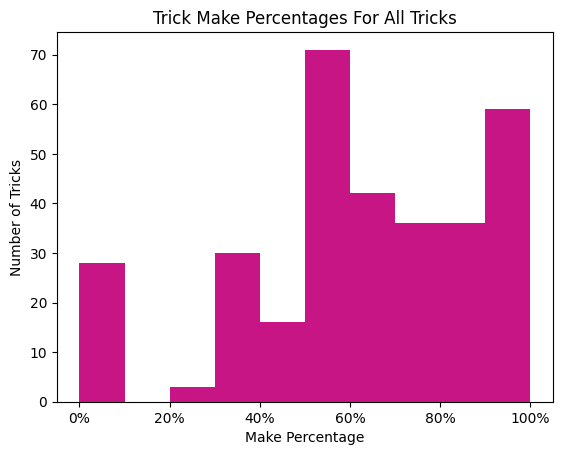

In [7]:
def plot_trick_makes_histogram():
    '''
    This function creates a histogram of all tricks and their make rates.

    Returns
    -------
    None.

    '''
    tricks_df = tricks.copy()

    # remove tricks that were never done (attempt_count = 0)
    tricks_df = tricks_df[tricks_df['attempt_count'] != 0]
    
    # sort by make rate
    tricks_df = tricks_df.sort_values('make_rate',ascending=True)    
    
    # histogram
    plt.hist(tricks_df['make_rate'],color='mediumvioletred')
    
    # change decimal rates to percentages
    plt.xticks([0,0.2,0.4,0.6,0.8,1.0],['0%','20%','40%','60%','80%','100%'])
    
    # label the axis and title, save figure
    plt.xlabel('Make Percentage')
    plt.ylabel('Number of Tricks')
    plt.title('Trick Make Percentages For All Tricks')
    plt.grid(False)
    plt.savefig('trick_histo_graph3',dpi=300,bbox_inches='tight')

    # show
    plt.show()
    
# call the function
plot_trick_makes_histogram()

#### Mean and Median Trick Consistencies

Next we will look at the mean and median trick consistencies, and the trick associated with the median.

In [8]:
def mean_and_median_consistencies():
    '''
    This function finds the mean and median trick consistencies, and the trick associated with the median.

    Returns
    -------
    total_make_rate : float
        overall trick consistency
    median : float
        median trick consistency
    median_trick : string
        same of the trick with the median trick consistency
    '''
    # drop rows with missing make rates (never attempted)
    tricks_df = tricks.dropna(subset='make_rate')

    # make an array with each entry being a trick's make rate times the attempt count
    average_array = []
    for index, trick in tricks_df.iterrows():
        average_array.append(trick['attempt_count']*trick['make_rate'])
    average_array = np.array(average_array)
    
    # calculate total attempts
    total_attempts = np.sum(tricks_df['attempt_count'])

    # calculate mean, meadian, and median_trick
    total_make_rate = sum(average_array) / total_attempts
    median = statistics.median(tricks_df['make_rate'])
    median_trick = tricks_df.loc[tricks_df['make_rate'] == median, 'name'].values[0]

    # return
    return total_make_rate, median, median_trick

print(f'''The overall make rate of all attempts is {round(mean_and_median_consistencies()[0]*100,3)}%.
The trick with the median make rate is {mean_and_median_consistencies()[2]} with a make rate of {round(mean_and_median_consistencies()[1]*100,3)}%.''')

The overall make rate of all attempts is 78.312%.
The trick with the median make rate is Switch Backside Bigspin with a make rate of 64.486%.


## Trick Variation Distribution

For this section, we will explore the differences between the trick variations (fakie, switch, nollie, and regular)
First we will get the attempt counts for each variation, then create a pie chart.

In [9]:
def attempt_counts_variations():
    regular_count = 0
    fakie_count = 0
    switch_count = 0
    nollie_count = 0
    for index, trick in tricks.iterrows():
        if trick['variation'] == 'regular':
            regular_count += trick['attempt_count']
        elif trick['variation'] == 'fakie':
            fakie_count += trick['attempt_count']
        elif trick['variation'] == 'switch':
            switch_count += trick['attempt_count']
        elif trick['variation'] == 'nollie':
            nollie_count += trick['attempt_count']
    return regular_count, fakie_count, switch_count, nollie_count
print(f'''Attempt counts are as follows:
regular: {attempt_counts_variations()[0]}
fakie: {attempt_counts_variations()[1]}
switch: {attempt_counts_variations()[2]}
nollie: {attempt_counts_variations()[3]}''')
        
        

Attempt counts are as follows:
regular: 6694
fakie: 3638
switch: 4816
nollie: 4310


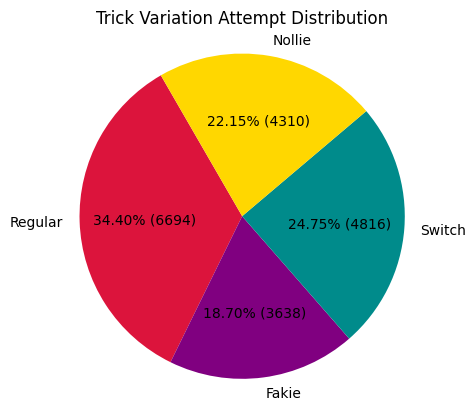

In [10]:
def variation_pie_chart():
    '''
    This function creates a pie chart showing the distribution of tricks attempted.

    Returns
    -------
    None.

    '''
    # get counts from previous function
    regular_count  = attempt_counts_variations()[0]
    fakie_count = attempt_counts_variations()[1]
    switch_count  = attempt_counts_variations()[2]
    nollie_count = attempt_counts_variations()[3]

    # make array
    array = np.array([regular_count, fakie_count, switch_count, nollie_count])
    total = sum(array)
    percents = []
    for i in array:
        percents.append((i / total)*100)
    
    # make labels
    variation_labels = ['Regular', 'Fakie', 'Switch', 'Nollie']

    # plot
    plt.pie(percents,labels=variation_labels, autopct=lambda p: '{:.2f}% ({:.0f})'.format(p,(p/100)*array.sum()),radius=1.1, colors=['crimson','purple','darkcyan','gold'],startangle=120)
    plt.title('Trick Variation Attempt Distribution')
    plt.savefig('pie_chart',dpi=300,bbox_inches='tight')
    plt.show()

variation_pie_chart()

Next we will calculate the make rates for each variation, and then plot them on a bar graph.

In [11]:
def variation_make_rates():
    ''' 
    This function finds the make rates for each trick variation.
    
    Returns
    -------
    mean_regular_rate : float
        mean make rate for regular tricks
    mean_fakie_rate : float
        mean make rate for regular tricks
    mean_switch_rate : float
        mean make rate for regular tricks
    mean_nollie_rate : float
        mean make rate for regular tricks
    '''
    # make lists for each variation, with rates of each trick
    regular_rates = []
    fakie_rates = []
    switch_rates = []
    nollie_rates = []
    
    # drop Nan
    tricks_df = tricks.dropna(subset='make_rate')

    # iterate through to fill lists
    for index, trick in tricks_df.iterrows():
        if trick['variation'] == 'regular':
            for i in range(trick['attempt_count']):
                regular_rates.append(trick['make_rate'])
        elif trick['variation'] == 'fakie':
            for i in range(trick['attempt_count']):
                fakie_rates.append(trick['make_rate'])
        elif trick['variation'] == 'switch':
            for i in range(trick['attempt_count']):
                switch_rates.append(trick['make_rate'])
        elif trick['variation'] == 'nollie':
            for i in range(trick['attempt_count']):
                nollie_rates.append(trick['make_rate'])
    # find means
    mean_regular_rate = statistics.mean(regular_rates)
    mean_fakie_rate = statistics.mean(fakie_rates)
    mean_switch_rate = statistics.mean(switch_rates)
    mean_nollie_rate = statistics.mean(nollie_rates)

    return mean_regular_rate, mean_fakie_rate, mean_switch_rate, mean_nollie_rate

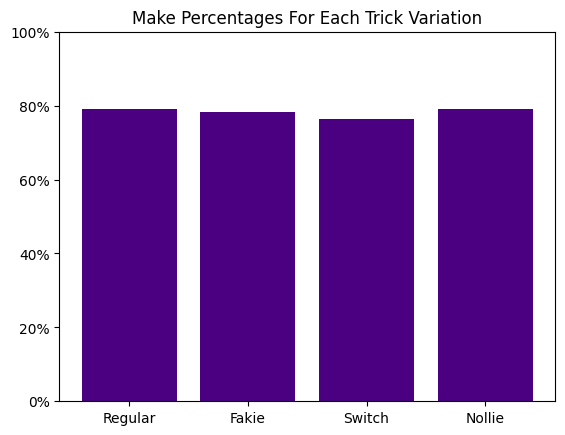

In [12]:
def variation_bar_graph():
    '''
    This function creates a bar graph showing make rates for each trick.

    Returns
    -------
    None.

    '''
    # create the bar graph
    plt.bar(['Regular','Fakie','Switch','Nollie'],variation_make_rates(),color='indigo')
    plt.yticks([0,0.2,0.4,0.6,0.8,1.0],['0%','20%','40%','60%','80%','100%'])
    plt.title('Make Percentages For Each Trick Variation')
    plt.grid(False)
    plt.savefig('trick_variation_bar',dpi=300,bbox_inches='tight')
    # show
    plt.show()

variation_bar_graph()

In terms of the pie chart, my prediction was correct besides fakie being the least popular. The order I predicted for land rates was incorrect, but regular was correctly predicted as having the highest land rate.

## Trick Popularity Vs. Make Rate Regression

For this section, we will use simple linear regression to investigate how trick popularity correlates with make rate. 

#### Linear Regression Model and Analysis

In [13]:
def linear_regression(df, features, response):
    '''
    This function performs simple or multiple linear regression

    Parameters
    ----------
    df : DataFrame
        The data frame that we will perform multiple linear regression on
    features : list
        List of feature names
    response : list
        name of the response
        
    Returns
    -------
    model : object
        linear regression model
    test_predictions : DataFrame
        predictions of test values
    all_predictions : DataFrame
        all predictions of values
    y_test : DataFrame
        contains test data (response)
    y : DataFrame
        contains y values (response)
    X_Test : DataFrame
        contains test data (features)
    X : DataFrame
        contains all data (features)
        '''
   # drop missing values
    df = df.dropna(subset=features + response)
    X = df[features]
    y = df[response]
   
   # train dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)
   
   # Linear regression model training and predictions
    model = LinearRegression()
    model.fit(X_train, y_train)
    test_predictions = model.predict(X_test)
    all_predictions = model.predict(X)

    return model, test_predictions,all_predictions, y_test, y, X_test, X

Now that we've constructed a model, lets find the root-mean-square-error (RMSE), pearson r-value, and p-values, once with all the data, and once removing tricks that were attempted less than five times.

In [14]:
def regression_analysis(data):
    '''
    
    Parameters
    ----------
    data

    Returns
    -------
    rmse : float
        rmse for regression
    pearson_r : float
        pearson correlation coefficient
    p_value : float
        p-value test
    r_squared : float
        r-squared test value
    '''
    model, test_predictions,all_predictions, y_test, y, X_test, X = data
    # min-max normalize data for rmse
    scaler = MinMaxScaler()
    y_true_norm = scaler.fit_transform(y).ravel()
    y_predicted_norm = scaler.transform(all_predictions).ravel()
    # find statistical values (rmse is based on normalized data)
    rmse = metrics.root_mean_squared_error(y_true_norm,y_predicted_norm)
    pearson_r, p_value = stats.pearsonr(X, y)
    r_squared = metrics.r2_score(y,all_predictions) 
    return rmse, pearson_r[0], p_value[0], r_squared

# make variables for data 
data_all_tricks = linear_regression(tricks,['attempt_count'],['make_rate'])
tricks_attempted_often = tricks[tricks['attempt_count']>=50]
data_exclude_tricks = linear_regression(tricks_attempted_often,['attempt_count'],['make_rate']) # tricks_attempted_often include only tricks attempted at least 5 times

# print the results
print(f'Analysis 1 Results (all tricks considered):\nrmse (normalized data) = {regression_analysis(data_all_tricks)[0]}\npearson_r = {regression_analysis(data_all_tricks)[1]}\nr_squared = {regression_analysis(data_all_tricks)[3]} \np = {regression_analysis(data_all_tricks)[2]}\n')
print(f'Analysis 2 Results (popularly performed tricks considered):\nrmse (normalized data) = {regression_analysis(data_exclude_tricks)[0]}\npearson_r = {regression_analysis(data_exclude_tricks)[1]}\nr_squared = {regression_analysis(data_exclude_tricks)[3]} \np = {regression_analysis(data_exclude_tricks)[2]}\n')


Analysis 1 Results (all tricks considered):
rmse (normalized data) = 0.2679473294055995
pearson_r = 0.3088186192250991
r_squared = 0.09527849626517915 
p = 1.6039800458244453e-08

Analysis 2 Results (popularly performed tricks considered):
rmse (normalized data) = 0.18689644631609653
pearson_r = 0.6130212610298651
r_squared = 0.36413915949255515 
p = 5.707417326360106e-10



##### Analysis 1: All Tricks Considered:
RMSE (normalized data): This RMSE for the normalized data is 0.27. This signifies a 27% deviation in predicted data from actual data.\
Pearson r Value: The Pearson r value or correlation coefficient is 0.31. This signifies a low to medium correlation between attempt count and make rate while considering all tricks.\
R Squared: The R Squared value is about 0.1. This signifies that the model does not fit the data well.\
p value: The p value is extremely low, showing a strong statistical significance of the observed correlation.
##### Analysis 2: Popularly Performed Tricks Considered:
RMSE (normalized data): This RMSE for the normalized data is 0.18. This signifies an 18% deviation in predicted data from actual data, more accurate the considering all tricks.\
Pearson r Value: The Pearson r value or correlation coefficient is 0.61. This signifies a medium to high correlation between attempt count and make rate while considering all tricks.\
R Squared: The R Squared value is about 0.36. This signifies a decent improvement from the previous model.\
p value: The p value is extremely low, showing a strong statistical significance of the observed correlation.
##### Overall Analysis: 
Considering only popular tricks leads to a stronger correlation between attempt count and make rate. This is because there are a lot of tricks with very small attempt counts, making their make rates less significant. The regression model performs moderately better when rarely done tricks are filtered out. 

#### Regression Plots for All Tricks and Popular Tricks

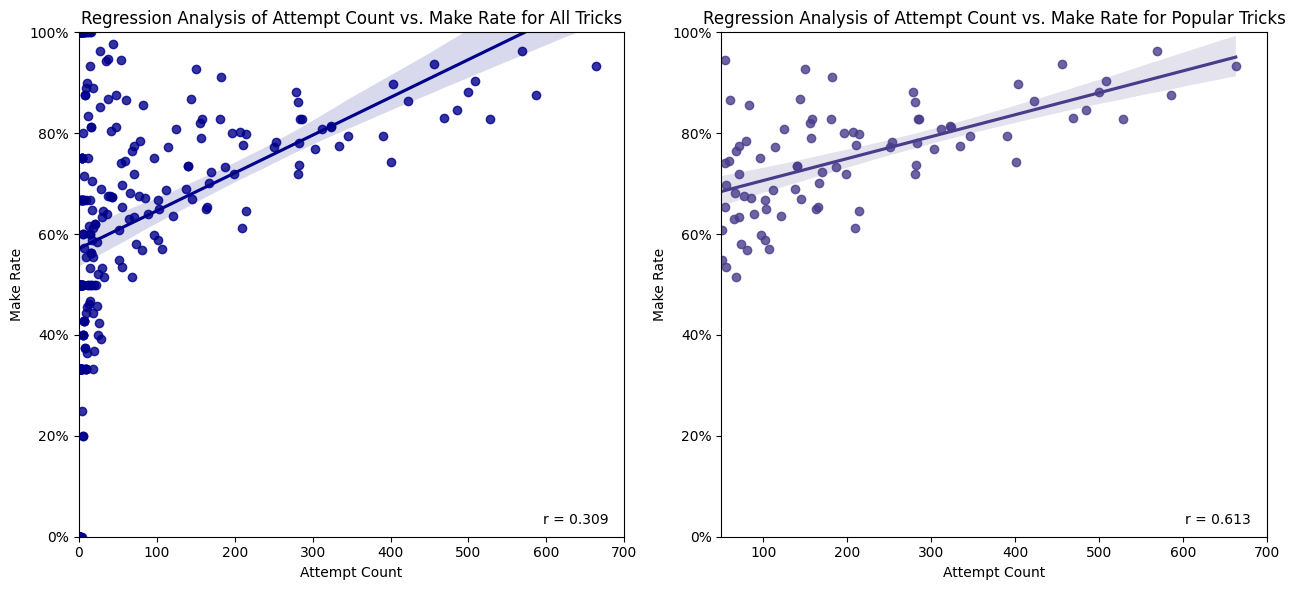

In [15]:
def regression_sub_plot(ax,which_plot):
    '''
    This function creates subplots based on which plot is being used

    Parameters
    ----------
    ax : object
        graph object.
    which_plot : string
        either 'all' or 'exclude'. used to make the two graphs have different titles, colors, etc.

    Returns
    -------
    None.

    '''
    
    # change the data being plotted and other parts of the graph based on the which_graph parameter
    if which_plot == 'all':
        y,X = linear_regression(tricks,['attempt_count'],['make_rate'])[4], linear_regression(tricks,['attempt_count'],['make_rate'])[6]
        min_x = 0
        title = 'Regression Analysis of Attempt Count vs. Make Rate for All Tricks'
        r_annotation = f'r = {regression_analysis(data_all_tricks)[1].round(3)}'
        color = 'darkblue'
    elif which_plot == 'exclude':
        y,X = linear_regression(tricks_attempted_often,['attempt_count'],['make_rate'])[4], linear_regression(tricks_attempted_often,['attempt_count'],['make_rate'])[6]
        min_x = 50
        title = 'Regression Analysis of Attempt Count vs. Make Rate for Popular Tricks'
        r_annotation = f'r = {regression_analysis(data_exclude_tricks)[1].round(3)}'
        color = 'darkslateblue'
    # create the plot
    sns.regplot(x=X,y=y,ax=ax,color=color)
    ax.set_xlim([min_x,700])
    ax.set_ylim([0,1])
    ax.set_title(title)
    ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0],['0%','20%','40%','60%','80%','100%'])
    ax.set_xlabel('Attempt Count')
    ax.set_ylabel('Make Rate')
    ax.annotate(r_annotation,(0.85,0.025),xycoords='axes fraction')
    ax.grid(False)
    
def regression_plots():
    '''
    This function takes subplots from regression_sub_plot and puts them into one
    image.

    Returns
    -------
    None.

    '''
    # make subplots
    f, (ax_all, ax_popular) = plt.subplots(1, 2,figsize=(13, 6))
    ax_all = regression_sub_plot(ax_all, 'all')
    ax_popular = regression_sub_plot(ax_popular, 'exclude')
    
    # save fig
    plt.tight_layout()
    plt.savefig('regression_plots', dpi=300)
    
    # show
    plt.show()
regression_plots()

As we can see of the graphs, filtering out tricks with less than 50 attempts leads to a stronger correlation, and higher correlation coefficient.

## Logistic Regression Model to Predict Who Will Win In a Game of S.K.A.T.E. Between Two Skaters 

For the final analysis, we will create a model to predict who will in S.K.A.T.E. between two skaters. The features we will take into account are each skater's win rate, and make rate, totalling in four features.\
\
First, we need to create new dataframe containing each skater's information.

In [16]:
def skater_info():
    '''
    This function creates a dataframe containing information for each 
    skater. 

    Returns
    -------
    skaters_df : DataFrame
        A DataFrame containing information on each skater such as land rate and win rate
    roshambo_ww_rate : float
        The chance that a skater who won roshambo wins the match
    '''
    # create the data frame
    skaters_dict = SKATE_DATA['data']['skaters']
    skaters_df = pd.DataFrame(skaters_dict)
    
    # sort the skaters by name
    skaters_df = skaters_df.sort_values('fullName',ascending=True)
    

    # iterate through the data frame and extract make and miss counts for each skater, as well as win counts and roshambo
    # do this using arrays
    make_array  = []
    miss_array = []
    win_array = []
    loss_array = []
    roshambo_win_win = 0   # when someone wins roshambo and wins the match
    roshambo_win_loss = 0  # when someone wins roshambo and loses the match
    for index, skater in skaters_df.iterrows():        
        make_count = 0
        miss_count = 0
        win_count = 0
        loss_count = 0
        for game in skater['games']:
            try:
                if game['result']['winner']['id'] == skater['id']:
                    win_count += 1
                    win = True
                elif game['result']['winner']['id'] != skater['id']:
                    loss_count += 1
                    win = True
            except:
                pass
            # only look at whose turn it is on the first iteration, to determine who won roshambo
            turn = 1 
            for attempt in game['attempts']:
                if turn == 1:
                    if attempt['skater']['id'] == skater['id']:
                        roshambo_win = True
                    elif attempt['skater']['id'] != skater['id']:
                        roshambo_win = False
                turn = 0
                if attempt['successful'] == True and attempt['skater']['id'] == skater['id']:
                    make_count += 1
                
                elif attempt['successful'] == False and attempt['skater']['id'] == skater['id']:
                    miss_count += 1
        if roshambo_win == win:
            roshambo_win_win += 1
        else:
            roshambo_win_loss += 1
        make_array.append(make_count)
        miss_array.append(miss_count)
        win_array.append(win_count)
        loss_array.append(loss_count)
        
        
    make_array = np.array(make_array)
    win_array = np.array(win_array)
    
    # add make and miss count columns with data, as well as win and loss counts with data
    skaters_df = skaters_df.assign(make_count=make_array,miss_count=miss_array)
    skaters_df = skaters_df.assign(win_count=win_array,loss_count=loss_array)

    # create total attempts and make rate columns
    skaters_df['total_attempts'] = skaters_df['make_count'] + skaters_df['miss_count']
    skaters_df['make_rate'] = skaters_df['make_count']/skaters_df['total_attempts']
    # create total matches and win rate columns
    skaters_df['total_matches'] = skaters_df['win_count'] + skaters_df['loss_count']
    skaters_df['win_rate'] = skaters_df['win_count']/skaters_df['total_matches']
    
    # drop the games column (the dictionary)
    skaters_df = skaters_df.drop(columns='games')
    
    # now we will create an array containing win rates for: roshambo winner, roshambo loser
    # in other words, how does roshambo affect the win rate
    roshambo_win_array = [roshambo_win_win, roshambo_win_loss]
    
    # find the win rate for roshambo winners and losers
    roshambo_ww_rate = roshambo_win_array[0] / sum(roshambo_win_array)   # rate at which someone who wins roshambo wins the match
    #roshambo_wl_rate =  roshambo_win_array[1] / sum(roshambo_win_array)   # how often someone who wins roshambo loses the match
    # return the data frame
    return skaters_df, roshambo_ww_rate
# create a global variable
roshambo_ww_rate = skater_info()[1]
skaters = skater_info()[0]
skaters

,id,fullName,make_count,miss_count,win_count,loss_count,total_attempts,make_rate,total_matches,win_rate
0,214,Adrianne Sloboh,11,8,0,1,19,0.578947,1,0.000000
1,25,Albert Nyberg,28,11,0,2,39,0.717949,2,0.000000
2,195,Alec Majerus,6,5,0,1,11,0.545455,1,0.000000
3,73,Alex Mizurov,60,11,1,1,71,0.845070,2,0.500000
4,215,Alexis Sablone,38,33,2,2,71,0.535211,4,0.500000
...,...,...,...,...,...,...,...,...,...,...
197,47,Wes Kremer,48,9,2,0,57,0.842105,2,1.000000
198,3,Wieger Van Wageningen,3,5,0,1,8,0.375000,1,0.000000
199,32,Will Fyock,188,39,5,3,227,0.828194,8,0.625000
200,194,Youness Amrani,135,34,4,2,169,0.798817,6,0.666667


In [17]:
print(roshambo_ww_rate)

0.47029702970297027


Very suprisingly, winning roshambo actually gives slightly worse odds at winning. Now that we've created the dataframe, we will move onto creating a logistic regression model.\
\
Next, we will create a DataFrame of all the matches played.

In [18]:
def matches_info():
    '''
    This function creates a dataframe containing information for each 
    match played. 

    Returns
    -------
    matches_df : DataFrame
        A DataFrame containing information on match such as who won and letters against.
    '''
    matches_dict = SKATE_DATA['data']['games']
    matches_df = pd.DataFrame(matches_dict)
    skater_name_array1 = []
    skater_name_array2 = []
    skater_id_array1 = []
    skater_id_array2 = []
    letters_against_array = []
    winner_name_array = []
    winner_number_array =[]     # if skater 1 wins, winner = 1, if skater 2 wins, winner = 0
    
    for index, game in matches_df.iterrows():
        for i in range(1,3,1):
            if i == 1:
                skater1_name = game['skaters'][0]['fullName']
                skater1_id = game['skaters'][0]['id']
            if i == 2:
                skater2_name = game['skaters'][1]['fullName']
                skater2_id = game['skaters'][1]['id']
        try:
            letters_against = game['result']['lettersAgainst']
            winner_name = game['result']['winner']['fullName']
        except:
            pass
        # append values
        skater_name_array1.append(skater1_name)
        skater_name_array2.append(skater2_name)
        skater_id_array1.append(skater1_id)
        skater_id_array2.append(skater2_id)
        letters_against_array.append(letters_against)
        winner_name_array.append(winner_name)
        if winner_name == skater1_name:
            winner_number_array.append(1)
        else:
            winner_number_array.append(0)

    # create new columns
    matches_df = matches_df.assign(skater1_name=skater_name_array1,skater2_name=skater_name_array2,skater21_id=skater_id_array1,skater2_id=skater_id_array2, letters_against=letters_against_array,winner_name=winner_name_array,winner_number=winner_number_array)
    
    # columns with players stats from skaters DataFrame
    matches_df['skater1_win_rate'] = matches_df['skater1_name'].apply(lambda name: skaters.loc[skaters['fullName'] == name, 'win_rate'].values[0])
    matches_df['skater1_make_rate'] = matches_df['skater1_name'].apply(lambda name: skaters.loc[skaters['fullName'] == name, 'make_rate'].values[0])
    matches_df['skater2_win_rate'] = matches_df['skater2_name'].apply(lambda name: skaters.loc[skaters['fullName'] == name, 'win_rate'].values[0])
    matches_df['skater2_make_rate'] = matches_df['skater2_name'].apply(lambda name: skaters.loc[skaters['fullName'] == name, 'make_rate'].values[0])

    # drop the games column (the dictionary)
    matches_df = matches_df.drop(columns=['skaters','result'])
    
    return matches_df

matches = matches_info()
matches

,id,skater1_name,skater2_name,skater21_id,skater2_id,letters_against,winner_name,winner_number,skater1_win_rate,skater1_make_rate,skater2_win_rate,skater2_make_rate
0,36,Trent McClung,Cody Cepeda,9,4,4,Cody Cepeda,0,0.250000,0.800752,0.785714,0.841432
1,38,"Luis ""Moose"" De Los Reyes",CJ Tambornino,21,18,4,"Luis ""Moose"" De Los Reyes",1,0.545455,0.815013,0.000000,0.766667
2,37,Eric Koston,Chhandy Khon,1,16,1,Eric Koston,1,0.571429,0.768116,0.000000,0.611111
3,72,Chris Cole,Mike Vallely,11,91,4,Chris Cole,1,0.650000,0.820561,0.000000,0.750000
4,73,Jamie Thomas,Dennis Busenitz,97,45,0,Dennis Busenitz,0,0.000000,0.588235,0.285714,0.785714
...,...,...,...,...,...,...,...,...,...,...,...,...
378,381,Manny Santiago,Sierra Fellers,48,232,4,Sierra Fellers,0,0.250000,0.753968,1.000000,0.801980
379,382,TJ Rogers,Taylor Kirby,210,233,4,TJ Rogers,1,0.600000,0.795580,0.666667,0.791667
380,383,Dan Plunkett,Sierra Fellers,174,232,0,Sierra Fellers,0,0.500000,0.696970,1.000000,0.801980
381,384,TJ Rogers,Sierra Fellers,210,232,4,Sierra Fellers,0,0.600000,0.795580,1.000000,0.801980


#### Logistic Regression Model and Analysis


Now we will construct the logistic regression model. We will normalize features to improve our model's accuracy.

In [19]:
def logistic_regression(df, features, response):
    '''
    This function performs simple or multiple logistic regression

    Parameters
    ----------
    df : DataFrame
        The data frame that we will perform multiple linear regression on
    features : List
        List of feature names
    response : List
        name of the response
        
    Returns
    -------
    model : object
        linear regression model
    test_predictions : DataFrame
        predictions of test values
    all_predictions : DataFrame
        all predictions of values
    y_test : DataFrame
        contains test data (response)
    y : DataFrame
        contains y values (response)
    X_Test : DataFrame
        contains test data (features)
    X : DataFrame
        contains all data (features)
    X_scaled : DataFrame
        contains scaled data (features)
        '''
   # drop missing values
    df = df.dropna(subset=features + response)
    X = df[features]
    y = df[response]
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
   # train dataset
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=0, test_size=0.2)
   
   # Linear regression model training and predictions
    model = LogisticRegression()
    model.fit(X_train, y_train)
    test_predictions = model.predict(X_test)
    all_predictions = model.predict(X)

    return model, test_predictions,all_predictions, y_test, y, X_test, X, X_scaled  

Now that we have constructed the model, we will do some analysis with our model.

In [20]:
def logistic_regression_analysis():
    '''
    This function performs analysis of the logistic regression model

    Returns
    -------
    classification_report : object
        report showing data from the classification
    roshambo_ww_rate : float
        The chance that a skater who won roshambo wins the match
    '''
    # get data from logistic regression function
    model, test_predictions,all_predictions, y_test, y, X_test, X, X_scaled  = logistic_regression(matches, ['skater1_win_rate','skater1_make_rate','skater2_win_rate','skater2_make_rate'], ['winner_number'])
    
    # do a classification report
    classification_report = metrics.classification_report(y_test, test_predictions)
    
    return classification_report

print(logistic_regression_analysis())

              precision    recall  f1-score   support

           0       0.87      0.71      0.78        28
           1       0.85      0.94      0.89        49

    accuracy                           0.86        77
   macro avg       0.86      0.83      0.84        77
weighted avg       0.86      0.86      0.85        77



As we can see, our model is performing well, with an accuracy score of 86%. _Keep in mind that skater 1 vs. skater 2 is arbitrary, it does not matter which skater is 1 and which is 2_. Next, we will plot the logistic regression decision boundaries.

#### Decision Boundary Plots

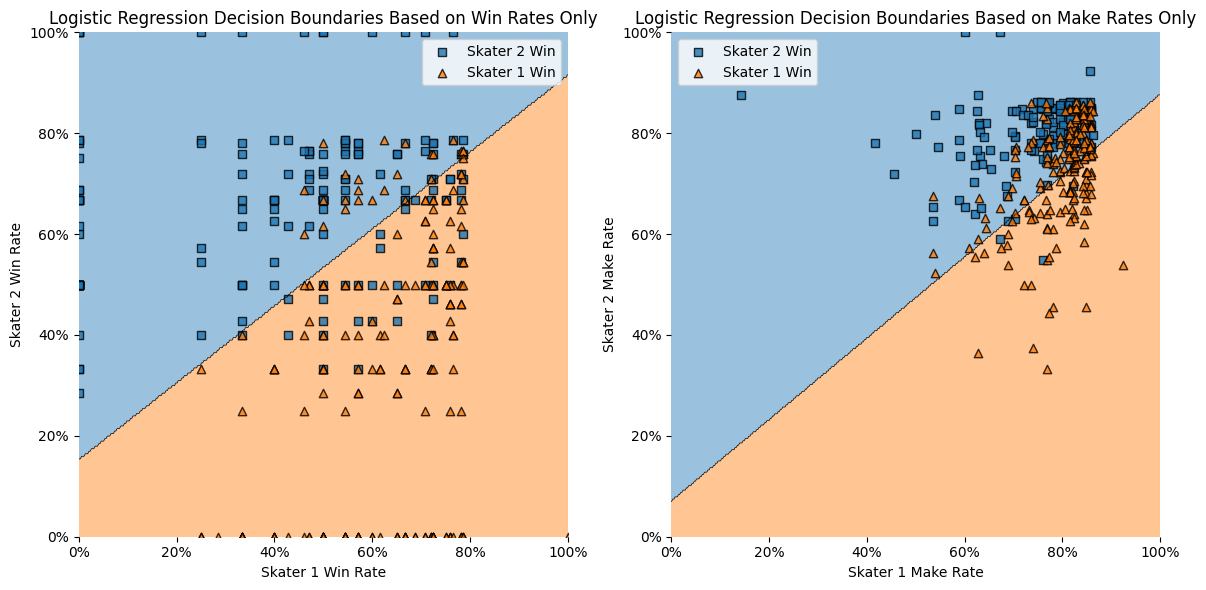

In [21]:
def plot_logistic_regression(ax,features_of_interest):
    '''
    This function creates subplots based on which plot is being used.

    Parameters
    ----------
    ax : object
        graph object.
    features_of_interest : list
        list of the features being plotted
    Returns
    -------
    None.

    '''
    # get data from logistic regression function
    model, test_predictions,all_predictions, y_test, y, X_test, X, X_scaled  = logistic_regression(matches, features_of_interest, ['winner_number'])
    
    # plot
    plot_decision_regions(X.to_numpy(), y.to_numpy().ravel(), clf=model, legend=2,ax=ax)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0],['0%','20%','40%','60%','80%','100%'])
    ax.set_xticks([0,0.2,0.4,0.6,0.8,1.0],['0%','20%','40%','60%','80%','100%'])
    if features_of_interest == ['skater1_make_rate', 'skater2_make_rate']:
        ax.set_xlabel('Skater 1 Make Rate')
        ax.set_ylabel('Skater 2 Make Rate')
        ax.set_title('Logistic Regression Decision Boundaries Based on Make Rates Only')

    else:
        ax.set_xlabel('Skater 1 Win Rate')
        ax.set_ylabel('Skater 2 Win Rate')
        ax.set_title('Logistic Regression Decision Boundaries Based on Win Rates Only')
    ax.grid(False)
    ax.legend(labels=['Skater 2 Win','Skater 1 Win'])

def logistic_regression_plots():
    '''
    This function plots both subplots.
    Returns
    -------

    '''
    # make subplots
    f, (ax_win, ax_make) = plt.subplots(1, 2,figsize=(12, 6))
    
    # plot subplots
    ax_make = plot_logistic_regression(ax_make,['skater1_make_rate', 'skater2_make_rate'])
    ax_win = plot_logistic_regression(ax_win,['skater1_win_rate', 'skater2_win_rate'])
    
    # save fig
    plt.tight_layout()
    plt.savefig('logistic_regression_plots', dpi=300)
    
    
    # show
    plt.show()
logistic_regression_plots()
    

Keep in mind that these plots are for logistic regression with only two features (either the win rates or make rates), hence it is a weaker model than taking into account all four features.


#### Testing Our Model
Next we will test our model by making the model guess the outcomes of specific matches. I will be manually picking matches that actually happened, as well as making up theoretical matches for our model to make predictions on.\
\
First lets make a function to make our predictions.

In [22]:
def predict_winner(skater1_name, skater2_name):
    '''
    This function creates predicts who will win a game of S.K.A.T.E. between two skaters, whether or not the match actually happened.

    Parameters
    ----------
    skater1_name : string
        name of the first skater
    skater2_name : string
        name of the second skater
    Returns
    -------
    None.

    '''
    # Define columns used for prediction
    columns = ['skater_name1', 'skater_name2', 'skater1_win_rate', 'skater1_make_rate', 'skater2_win_rate', 'skater2_make_rate']
    
    # Call logistic_regression to get the model (Assuming model is already trained)
    model, test_predictions, all_predictions, y_test, y, X_test, X, X_scaled = logistic_regression(matches, columns[2:], ['winner_number'])

    # Filter skater data
    X1 = skaters[skaters['fullName'] == skater1_name]
    X2 = skaters[skaters['fullName'] == skater2_name]
        
    # Create DataFrame for prediction
    X = pd.DataFrame({
        'skater1_win_rate': [X1['win_rate'].values[0]],
        'skater1_make_rate': [X1['make_rate'].values[0]],
        'skater2_win_rate': [X2['win_rate'].values[0]],
        'skater2_make_rate': [X2['make_rate'].values[0]]
    })
    
    # Predict the winner and probabilty
    prediction = model.predict(X)
    percent_chances = model.predict_proba(X) * 100
    percents = pd.DataFrame(percent_chances, columns=['Probability Skater 1 Wins (%)', 'Probability Skater 2 Wins (%)'])

    # Determine winner based on prediction
    if prediction == 0:
        predicted_winner = skater2_name
        predicted_winner_prob = percent_chances[0][0]
    else:
        predicted_winner = skater1_name
        predicted_winner_prob = percent_chances[0][1]
    # check if the match actually happened, if so give the actual winner
    match = matches[(matches['skater1_name'] == skater1_name) & (matches['skater2_name'] == skater2_name)]
    if not match.empty:
        actual_winner = match['winner_name'].values[0]
        print(f'The predicted winner of this match is {predicted_winner} with a probability of {predicted_winner_prob:.2f}%.')
        print(f'The actual winner was {actual_winner}.')
    else:
        print(f'The match between {skater1_name} and {skater2_name} has not happened or is not in the data.')
        print(f'The predicted winner would be {predicted_winner} with a probability of {predicted_winner_prob:.2f}%.')


 The first match we will be looking at is Ishod Wair vs. Louis Lopez at Battle at the Berrics 11.


In [23]:
predict_winner('Ishod Wair','Louie Lopez')

The predicted winner of this match is Ishod Wair with a probability of 72.81%.
The actual winner was Ishod Wair.


The second match we will be looking at is Cody Cepeda vs. Luan Oliveira at the Battle at the Berrics 7 Finals

In [24]:
predict_winner('Cody Cepeda','Luan Oliveira')

The predicted winner of this match is Luan Oliveira with a probability of 56.58%.
The actual winner was Cody Cepeda.


Now lets look at some theoretical match ups. \
\
First lets look at Chris Joslin vs. PJ Ladd.


In [25]:
predict_winner('Chris Joslin','PJ Ladd')

The match between Chris Joslin and PJ Ladd has not happened or is not in the data.
The predicted winner would be PJ Ladd with a probability of 57.80%.


Next, we will look at Paul Rodriguez vs. Chad Tim Tim.

In [26]:
predict_winner('Paul Rodriguez','Chad Tim Tim')

The match between Paul Rodriguez and Chad Tim Tim has not happened or is not in the data.
The predicted winner would be Paul Rodriguez with a probability of 96.19%.


Keep in mind that some skaters have played many more matches than other skaters. Skaters also improve over time, making some matchups unfair. Even so, the model predicts real matches correctly 86% of the time.